In [14]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer,InputSpec
from keras.layers import Input
from keras.layers import ConvLSTM2D
from keras.models import Model
from keras.layers.wrappers import Bidirectional, TimeDistributed

K.set_image_dim_ordering("th")

class CylindricalPad(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalPad, self).__init__(**kwargs)
        self.n = n
        self.m = m
        #assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPad, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + 2*self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] + self.m,
                    input_shape[3] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    #input_shape[2] + 2*self.m,
                    # ONLY ADD m 0's to the left for casusal padding
                    input_shape[2] + self.m,
                    input_shape[3] + 2*self.n)
    
    def call(self,testElement, mask=None):
        firstColumns=testElement[:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,testElement.shape[3]-self.n:testElement.shape[3]]
        result=tf.concat([testElement,firstColumns], axis=3)
        result=tf.concat([lastColumns,result], axis=3)
        if self.m != 0 :
            #x = tf.placeholder(result.dtype, shape=[result.shape[0],result.shape[1],self.m,result.shape[3]])
            #y = tf.zeros_like(x,dtype=result.dtype)
            
            firstRows=result[:,:,0:self.m,:]
            
            #y = tf.fill(tf.shape(firstRows), 0.)
            sa=tf.shape(firstRows)[0]
            sb=tf.shape(firstRows)[1]
            sc=self.m
            sd=tf.shape(firstRows)[3]
            y = tf.fill([sa, sb,sc, sd], 0.)
            
            #y=tf.fill([result.shape[0],result.shape[1],self.m,result.shape[3]],0.)
            
            #y = tf.constant(0., shape=[result.shape[0],result.shape[1],self.m,result.shape[3]],dtype=result.dtype)
            result=tf.concat([y,result], axis=2)
            
            ########## only add 0's to de left for casusal pading
            #############result=tf.concat([result,y], axis=2)
        
        return result

    def get_config(self):
        config = {'n': self.n,
        'm': self.m}
        base_config = super(CylindricalPad, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

print("CylindricalPad class layer defined")


class CNNLSTM:
    @staticmethod
    def build(timeSteps,rows, cols,classes):
        
        inputNet = Input(shape=(timeSteps,1,rows, cols)) #batch_shape=(20, 7, 5) 
        
        
        #convlstm2d=Bidirectional(ConvLSTM2D(20, kernel_size=(5,8), padding="same", dropout=0.2, recurrent_dropout=0.1,return_sequences=True))(inputNet)
        
        convlstm2d=ConvLSTM2D(10, kernel_size=(3,5), padding="same", dropout=0.2, recurrent_dropout=0.1)(inputNet)
        
        flat=Flatten()(convlstm2d)
        #denselayers=Dense(400)(flat)
        #denselayers=Activation("relu")(denselayers)
        #denselayers=Dropout(0.5)(denselayers)
        #denselayers=Dense(150)(denselayers)
        #denselayers=Activation("relu")(denselayers)
        #denselayers=Dropout(0.8)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(5)(flat)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        #classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model

CylindricalPad class layer defined


In [15]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('windows-size168-step12.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size168-step12.csv',header=None)  #output classes 

total_inputs,total_output = dfin.as_matrix().astype(np.float32),dfout.as_matrix().astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,168,8))
total_inputs = np.reshape(total_inputs, (-1,7,24,8))

print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)



############# total shapes #############
(2868, 7, 24, 8)
2868
############# train shapes #############
(2295, 7, 24, 8)
(2295, 1)
############# test shapes #############
(573, 7, 24, 8)
(573, 1)


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [16]:

IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs[:,:, np.newaxis, :, :]
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs[:,:, np.newaxis, :, :]
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = CNNLSTM.build(timeSteps=7,rows=24, cols=8,classes=5)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(573, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7, 1, 24, 8)       0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 10, 24, 8)         6640      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 9605      
_________________________________________________________________
activation_4 (Activation)    (None, 5)                 0         
Total params: 16,245
Trainable params: 16,245
Non-trainable params: 0
_________________________________________________________________


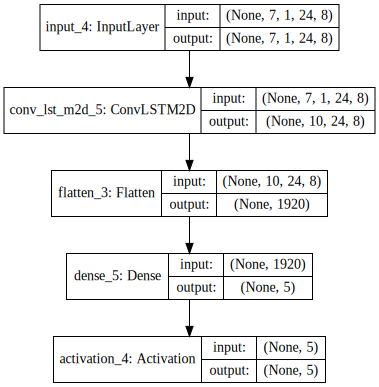

In [17]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [18]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('CNNLSTM-energie.h5', monitor='val_acc', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[reduce_lr,best_checkpoint])

Train on 2295 samples, validate on 573 samples
Epoch 1/100
2295/2295 [==============================] - 2s 906us/step - loss: 1.5665 - acc: 0.3002 - val_loss: 1.4887 - val_acc: 0.3455

Epoch 00001: val_acc improved from -inf to 0.34555, saving model to CNNLSTM-energie.h5
Epoch 2/100
2295/2295 [==============================] - 1s 457us/step - loss: 1.4551 - acc: 0.3577 - val_loss: 1.4402 - val_acc: 0.3368

Epoch 00002: val_acc did not improve from 0.34555
Epoch 3/100
2295/2295 [==============================] - 1s 475us/step - loss: 1.4293 - acc: 0.3725 - val_loss: 1.4341 - val_acc: 0.3543

Epoch 00003: val_acc improved from 0.34555 to 0.35428, saving model to CNNLSTM-energie.h5
Epoch 4/100
2295/2295 [==============================] - 1s 452us/step - loss: 1.4187 - acc: 0.3760 - val_loss: 1.4527 - val_acc: 0.3543

Epoch 00004: val_acc did not improve from 0.35428
Epoch 5/100
2295/2295 [==============================] - 1s 470us/step - loss: 1.4049 - acc: 0.3865 - val_loss: 1.4360 - val

2295/2295 [==============================] - 1s 452us/step - loss: 1.2731 - acc: 0.4610 - val_loss: 1.3401 - val_acc: 0.3997

Epoch 00043: val_acc did not improve from 0.42408
Epoch 44/100
2295/2295 [==============================] - 1s 460us/step - loss: 1.2740 - acc: 0.4675 - val_loss: 1.3422 - val_acc: 0.3909

Epoch 00044: val_acc did not improve from 0.42408
Epoch 45/100
2295/2295 [==============================] - 1s 470us/step - loss: 1.2793 - acc: 0.4606 - val_loss: 1.3431 - val_acc: 0.3962

Epoch 00045: val_acc did not improve from 0.42408
Epoch 46/100
2295/2295 [==============================] - 1s 473us/step - loss: 1.2743 - acc: 0.4654 - val_loss: 1.3394 - val_acc: 0.4049

Epoch 00046: val_acc did not improve from 0.42408
Epoch 47/100
2295/2295 [==============================] - 1s 461us/step - loss: 1.2723 - acc: 0.4571 - val_loss: 1.3410 - val_acc: 0.4049

Epoch 00047: val_acc did not improve from 0.42408
Epoch 48/100
2295/2295 [==============================] - 1s 471us/s

2295/2295 [==============================] - 1s 466us/step - loss: 1.2515 - acc: 0.4623 - val_loss: 1.3400 - val_acc: 0.4084

Epoch 00086: val_acc did not improve from 0.42408
Epoch 87/100
2295/2295 [==============================] - 1s 472us/step - loss: 1.2536 - acc: 0.4645 - val_loss: 1.3390 - val_acc: 0.4014

Epoch 00087: val_acc did not improve from 0.42408
Epoch 88/100
2295/2295 [==============================] - 1s 477us/step - loss: 1.2599 - acc: 0.4749 - val_loss: 1.3389 - val_acc: 0.3962

Epoch 00088: val_acc did not improve from 0.42408
Epoch 89/100
2295/2295 [==============================] - 1s 461us/step - loss: 1.2574 - acc: 0.4754 - val_loss: 1.3438 - val_acc: 0.3944

Epoch 00089: val_acc did not improve from 0.42408
Epoch 90/100
2295/2295 [==============================] - 1s 469us/step - loss: 1.2525 - acc: 0.4719 - val_loss: 1.3406 - val_acc: 0.3909

Epoch 00090: val_acc did not improve from 0.42408
Epoch 91/100
2295/2295 [==============================] - 1s 480us/s

In [19]:
import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n


saveHist('CNNLSTM-energie.hist',history)
hist=loadHist('CNNLSTM-energie.hist')




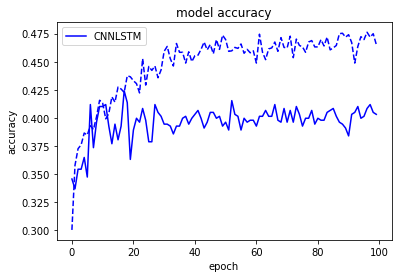

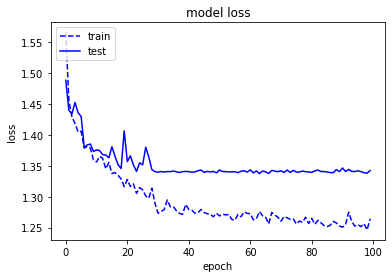

In [20]:
import matplotlib.pylab as plt

acc=np.array(hist['acc'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_acc'],'b',label='CNNLSTM')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
from keras.models import load_model
model = load_model('CNNLSTM-energie.h5')

In [22]:
from sklearn.metrics import classification_report, confusion_matrix


print('Confusion Matrix')
cm=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test),axis=1))
print(cm)
scores = model.evaluate(X_test,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pred = model.predict(X_test)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), predicted,digits=4)
print(report)


Confusion Matrix
[[71 34  0  7  3]
 [28 82  6 20  4]
 [12 58 23 40  8]
 [ 2 37  5 51 13]
 [ 6 14  7 26 16]]
Dados Validação acc: 42.41%
             precision    recall  f1-score   support

          0     0.5966    0.6174    0.6068       115
          1     0.3644    0.5857    0.4493       140
          2     0.5610    0.1631    0.2527       141
          3     0.3542    0.4722    0.4048       108
          4     0.3636    0.2319    0.2832        69

avg / total     0.4574    0.4241    0.4042       573



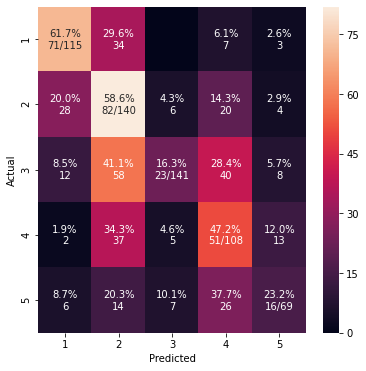

In [23]:
import seaborn as sns

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("LSTM-ATTENTION-CONV1D-BF-enegie.pdf")
    plt.show()
    
    
    
cm_analysis(np.argmax(y_test,axis=1),np.argmax(pred,axis=1), labels=["1","2","3","4","5"], ymap=None, figsize=(6,6))
